# Chargement des données

In [0]:
# On importe les librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler


In [2]:
#On importe le dataset global en précisant qu'il s'agit de time series (squeeze = True)

df = pd.read_csv('https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv',
                 sep = ',', 
                 parse_dates=[0], 
                 index_col=0, 
                 squeeze=True)
df.head()

,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market_Cap,...,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin
GOLD_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7764,7836,7515,7569,17158194786,136829391049,321,0.041416,0.042268,0.040068,0.040425,64184926,1048107282,0.002200,48.91,49.28,47.09,47.48,2678481167,3026175357,2.19,2.80,2.83,2.74,2.76,1537950803,2598670742,0.09,155,156,151,152,6565950868,16589132426,...,111.660,111.66,0.0,216.53,216.53,216.53,216.53,0.0,39.16,39.16,39.160,39.16,0.0,1304.98,1304.980,1304.98,1304.98,0.0,16.61,16.610,16.610,16.61,0.0,2512.405,2512.405,2512.405,2512.405,0.0,134.45,134.45,134.45,134.45,0.0,8.928571,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16
2019-11-29,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7466,7781,7460,7761,19709695456,140280108521,321,0.039227,0.042040,0.039194,0.041423,99506198,1073986624,0.002846,47.09,49.32,47.09,48.88,2944492393,3115330867,2.23,2.64,2.80,2.64,2.80,1899935358,2636173142,0.16,151,156,151,155,7503898278,16887922522,...,111.440,111.66,1798695.0,217.00,218.14,215.78,216.53,1881106.0,39.07,39.51,39.020,39.16,7526362.0,1305.50,1310.205,1303.97,1304.98,392185.0,16.91,16.930,16.570,16.61,1311527.0,2512.405,2512.405,2512.405,2512.405,0.0,133.59,134.51,133.04,134.45,773921.0,9.464286,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16
2019-11-28,1458.0,1455.0,1127.27,1127.35,1323.60,1321.84,7536,7730,7454,7463,19050116751,134879411013,276,0.039129,0.039990,0.038641,0.039190,60743403,1016079672,0.001349,48.00,48.55,47.02,47.06,2662459127,2998875250,1.53,2.69,2.76,2.62,2.64,1514999632,2483560320,0.14,153,156,151,151,7346531960,16496129470,...,111.660,111.66,0.0,218.24,218.24,218.24,218.24,0.0,39.41,39.41,39.410,39.41,0.0,1312.99,1312.990,1312.99,1312.99,0.0,16.91,16.910,16.910,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,133.76,133.76,133.76,133.76,0.0,10.714286,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-27,1459.8,1454.0,1134.12,1129.74,1326.23,1322.30,7220,7619,6974,7531,23991412764,136102712894,645,0.036955,0.039800,0.035783,0.039049,76841561,1012420887,0.004017,47.16,48.52,45.44,48.01,2979663352,3059223170,3.08,2.63,2.73,2.53,2.69,2247567344,2532133843,0.20,148,154,143,153,8778095308,16634910472,...,111.605,111.66,2334424.0,218.67,220.02,217.18,218.24,5314571.0,39.50,39.76,39.080,39.41,33127997.0,1315.00,1318.187,1309.63,1312.99,989345.0,17.01,17.150,16.710,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,135.28,135.70,133.63,133.76,0.0,11.428571,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16
2019-11-26,1458.0,1455.0,1133.76,1131.86,1322.96,1321.11,7145,7320,7098,7218,21129505542,130429018720,222,0.036046,0.037074,0.035705,0.036993,57431470,959117573,0.001369,45.81,47.54,45.66,47.27,2659405400,3012041642,1.88,2.53,2.65,2.53,2.63,1894353525,2479535254,0.12,146,150,145,148,7648516297,16193326033,...,111.850,111.95,3578750.0,220.50,220.69,216.75,217.00,9487105.0,38.99,39.48,38.815,38.99,42706750.0,1309.86,1314.760,1305.09,1313.55,1011135.0,17.11,17.265,16.855,17.01,0.0,2512.405,2512.405,2512.405,2512.405,0.0,136.01,136.15,134.77,135.03,0.0,11.785714,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16


# Exploration des données

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


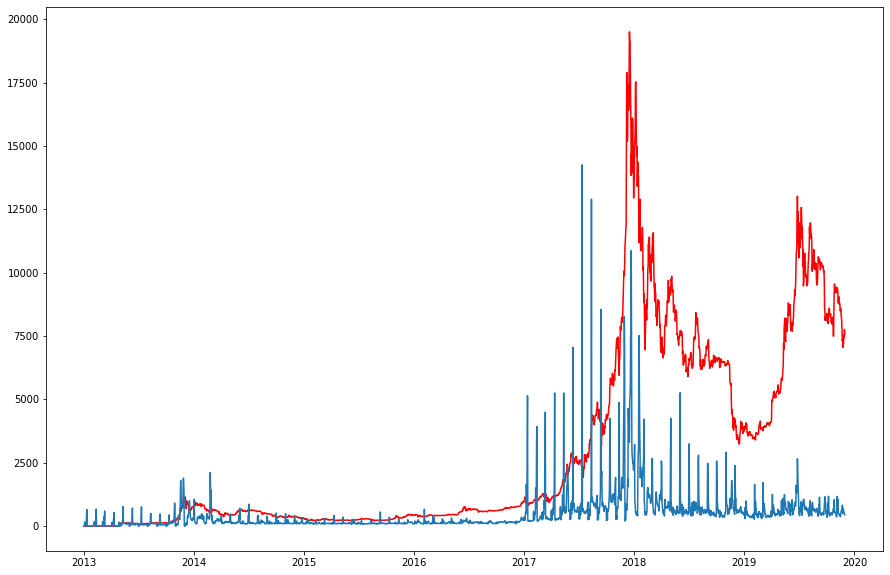

In [3]:
# On affiche Google Trends et le cours du Bitcoin BTC_Close sur le même graphique

plt.figure(figsize=(15,10))
plt.plot(df.BTC_Close, color='r')
plt.plot(df.GGTrends_values*50)
plt.show()

In [17]:
# On affiche les corrélations les plus grandes en valeur absolues

df.corr()['BTC_Close'].sort_values(ascending=True)[:20]
# On constate la grande corrélation entre les différents Altcoins et les recherches Google avec le BTC_Close

ICE_Close       -0.660399
ICE_High        -0.660199
ICE_Low         -0.659935
ICE_Open        -0.659837
CNYUSD_Low      -0.519462
CNYUSD_Open     -0.518139
CNYUSD_Close    -0.517418
CNYUSD_High     -0.517044
IBM_Close       -0.491645
IBM_High        -0.491559
IBM_Low         -0.490308
IBM_Open        -0.484886
GPS_Low         -0.427402
GPS_Close       -0.426486
GPS_Open        -0.426060
GPS_High        -0.424504
IBM_Volume      -0.405275
GPS_Volume      -0.380256
ICE_Volume      -0.355073
GOOGLE_Volume   -0.251581
Name: BTC_Close, dtype: float64

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


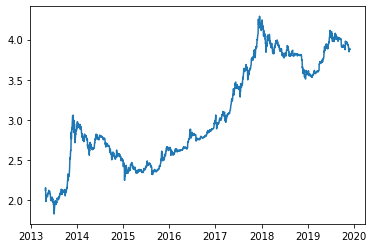

In [0]:
# On affiche le log10 du BTC_Close pour explorer les données
plt.plot(np.log10(df.BTC_Close))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


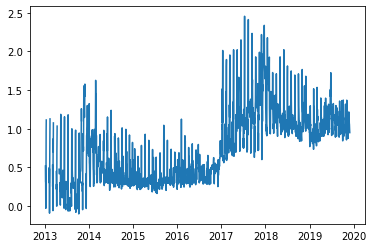

In [0]:
# On affiche également le log10 de Google Trends
plt.plot(np.log10(df.GGTrends_values))

# Préparation des données (Preprocessing)

In [0]:
# On définit une fonction qui récupère pour chaque ligne (date) les nb_day valeurs passées avec un décalage de nb_decal
# et réplique les colonnes val_exp (valeurs explicatives), chacune dans une nouvelle colonne et les juxtapose au colonnes
# contenues dans val_pred qui restent inchangées et non décalées. Cette fonction renvoie un nouveau DataFrame qui contient cette transformation
def Create_Df_Test_dec(df, val_pred, val_exp, nb_day, nb_decal):
    df2 = pd.DataFrame()
    df2['Date'] = df['GOLD_Time']
    
    # On récupère les colonnes à prédire
    for col_pred in val_pred:
        df2[col_pred] = df[col_pred]
    
    # Pour chacune des colonnes indicatives, on va récupérer les n-nb_day valeurs
    for col_exp in val_exp:
        for ii in range(nb_decal-1, nb_day):
            nb_col = ii+1
            new_col = col_exp + '_' + str(nb_col)
            df2[new_col] = 0.0
            for jj in range(len(df)):
                if ((jj+ii+1) >= len(df)):
                    df2[new_col].values[jj] = np.nan
                else:
                    df2[new_col].values[jj] = (df[col_exp].values[jj+ii+1])
    df2 = df2.set_index('Date')    
    return df2

In [0]:
# On charge à nouveau le fichier dans un DataFrame en précisant qu'il s'agit d'un TimeSeries de la colonne 0. On ne définit pas d'Index.
df_in = pd.read_csv('https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv',
                 sep = ',', 
                 parse_dates=[0], 
                 squeeze=True)
df_in.head()

,GOLD_Time,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,...,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin
0,2019-11-30,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7764,7836,7515,7569,17158194786,136829391049,321,0.041416,0.042268,0.040068,0.040425,64184926,1048107282,0.002200,48.91,49.28,47.09,47.48,2678481167,3026175357,2.19,2.80,2.83,2.74,2.76,1537950803,2598670742,0.09,155,156,151,152,6565950868,...,111.660,111.66,0.0,216.53,216.53,216.53,216.53,0.0,39.16,39.16,39.160,39.16,0.0,1304.98,1304.980,1304.98,1304.98,0.0,16.61,16.610,16.610,16.61,0.0,2512.405,2512.405,2512.405,2512.405,0.0,134.45,134.45,134.45,134.45,0.0,8.928571,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16
1,2019-11-29,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7466,7781,7460,7761,19709695456,140280108521,321,0.039227,0.042040,0.039194,0.041423,99506198,1073986624,0.002846,47.09,49.32,47.09,48.88,2944492393,3115330867,2.23,2.64,2.80,2.64,2.80,1899935358,2636173142,0.16,151,156,151,155,7503898278,...,111.440,111.66,1798695.0,217.00,218.14,215.78,216.53,1881106.0,39.07,39.51,39.020,39.16,7526362.0,1305.50,1310.205,1303.97,1304.98,392185.0,16.91,16.930,16.570,16.61,1311527.0,2512.405,2512.405,2512.405,2512.405,0.0,133.59,134.51,133.04,134.45,773921.0,9.464286,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16
2,2019-11-28,1458.0,1455.0,1127.27,1127.35,1323.60,1321.84,7536,7730,7454,7463,19050116751,134879411013,276,0.039129,0.039990,0.038641,0.039190,60743403,1016079672,0.001349,48.00,48.55,47.02,47.06,2662459127,2998875250,1.53,2.69,2.76,2.62,2.64,1514999632,2483560320,0.14,153,156,151,151,7346531960,...,111.660,111.66,0.0,218.24,218.24,218.24,218.24,0.0,39.41,39.41,39.410,39.41,0.0,1312.99,1312.990,1312.99,1312.99,0.0,16.91,16.910,16.910,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,133.76,133.76,133.76,133.76,0.0,10.714286,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16
3,2019-11-27,1459.8,1454.0,1134.12,1129.74,1326.23,1322.30,7220,7619,6974,7531,23991412764,136102712894,645,0.036955,0.039800,0.035783,0.039049,76841561,1012420887,0.004017,47.16,48.52,45.44,48.01,2979663352,3059223170,3.08,2.63,2.73,2.53,2.69,2247567344,2532133843,0.20,148,154,143,153,8778095308,...,111.605,111.66,2334424.0,218.67,220.02,217.18,218.24,5314571.0,39.50,39.76,39.080,39.41,33127997.0,1315.00,1318.187,1309.63,1312.99,989345.0,17.01,17.150,16.710,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,135.28,135.70,133.63,133.76,0.0,11.428571,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16
4,2019-11-26,1458.0,1455.0,1133.76,1131.86,1322.96,1321.11,7145,7320,7098,7218,21129505542,130429018720,222,0.036046,0.037074,0.035705,0.036993,57431470,959117573,0.001369,45.81,47.54,45.66,47.27,2659405400,3012041642,1.88,2.53,2.65,2.53,2.63,1894353525,2479535254,0.12,146,150,145,148,7648516297,...,111.850,111.95,3578750.0,220.50,220.69,216.75,217.00,9487105.0,38.99,39.48,38.815,38.99,42706750.0,1309.86,1314.760,1305.09,1313.55,1011135.0,17.11,17.265,16.855,17.01,0.0,2512.405,2512.405,2512.405,2512.405,0.0,136.01,136.15,134.77,135.03,0.0,11.785714,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16


In [0]:
# On précise les colonnes à répliquer et les colonnes à garder dans les deux listes val_pred et val_exp. La première colonne dans l'ordre de val_pred sera la valeur à prédire.
val_pred = ['BTC_Close', 'Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']
val_exp = ['BTC_Close', 'BTC_Intraday', 'BTC_Volume', 'BTC_Market_Cap',
           'NVIDIA_Close', 'AMD_Close', 'GOOGLE_Close', 'GPS_Close', 'IBM_Close', #Actions \
           'GOLD_USD_PM', # Or \
           'EURGBP_Close', 'EURHUF_Close', 'EURJPY_Close', 'EURUSD_Close', 'CNYUSD_Close', 'GBPUSD_Close', # FOREX \
           'IBB_Close', 'ICE_Close', 'IEF_Close',# INDEX
           'GGTrends_values'] #Google Trends

#On fait appel à la fonction pour transformer notre DataFrame et l'enregistrer dans df_out
df_out = Create_Df_Test_dec(df_in, val_pred, val_exp, 8, 2)

df_out.head(5)

,BTC_Close,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_2,NVIDIA_Close_3,NVIDIA_Close_4,NVIDIA_Close_5,NVIDIA_Close_6,...,CNYUSD_Close_4,CNYUSD_Close_5,CNYUSD_Close_6,CNYUSD_Close_7,CNYUSD_Close_8,GBPUSD_Close_2,GBPUSD_Close_3,GBPUSD_Close_4,GBPUSD_Close_5,GBPUSD_Close_6,GBPUSD_Close_7,GBPUSD_Close_8,IBB_Close_2,IBB_Close_3,IBB_Close_4,IBB_Close_5,IBB_Close_6,IBB_Close_7,IBB_Close_8,ICE_Close_2,ICE_Close_3,ICE_Close_4,ICE_Close_5,ICE_Close_6,ICE_Close_7,ICE_Close_8,IEF_Close_2,IEF_Close_3,IEF_Close_4,IEF_Close_5,IEF_Close_6,IEF_Close_7,IEF_Close_8,GGTrends_values_2,GGTrends_values_3,GGTrends_values_4,GGTrends_values_5,GGTrends_values_6,GGTrends_values_7,GGTrends_values_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,7569,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,7463.0,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,276.0,645.0,222.0,702.0,379.0,291.0,761.0,1.905012e+10,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,1.348794e+11,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,218.24,218.24,217.00,221.21,210.89,...,0.141084,0.141084,0.141084,0.141084,0.141084,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,119.39,119.39,118.48,118.25,115.41,115.41,115.41,93.44,93.44,94.50,94.31,93.76,93.76,93.76,111.66,111.66,111.95,111.74,111.69,111.69,111.69,10.714286,11.428571,11.785714,13.750000,10.000000,12.826087,16.521739
2019-11-29,7761,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,645.0,222.0,702.0,379.0,291.0,761.0,513.0,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,218.24,217.00,221.21,210.89,210.89,...,0.141084,0.141084,0.141084,0.141084,0.141084,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,119.39,118.48,118.25,115.41,115.41,115.41,114.30,93.44,94.50,94.31,93.76,93.76,93.76,93.88,111.66,111.95,111.74,111.69,111.69,111.69,111.71,11.428571,11.785714,13.750000,10.000000,12.826087,16.521739,13.695652
2019-11-28,7463,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,222.0,702.0,379.0,291.0,761.0,513.0,227.0,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,217.00,221.21,210.89,210.89,210.89,...,0.141084,0.141084,0.141084,0.141084,0.141084,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,118.48,118.25,115.41,115.41,115.41,114.30,113.96,94.50,94.31,93.76,93.76,93.76,93.88,94.46,111.95,111.74,111.69,111.69,111.69,111.71,111.99,11.785714,13.750000,10.000000,12.826087,16.521739,13.695652,11.304348
2019-11-27,7531,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,8206.0,702.0,379.0,291.0,761.0,513.0,227.0,309.0,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,2.108361e+10,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,1.481784e+11,221.21,210.89,210.89,210.89,210.18,...,0.141084,0.141084,0.141084,0.141084,0.141084,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,118.25,115.41,115.41,115.41,114.30,113.96,113.45,94.31,93.76,93.76,93.76,93.88,94.46,93.99,111.74,111.69,111.69,111.69,111.71,111.99,111.58,13.750000,10.000000,12.826087,16.521739,13.695652,11.304348,12.391304
2019-11-26,7218,-0.222521,0.974928,0.866025,-

In [0]:
# On remplace les NaN par 0
df_out = df_out.fillna(0)

In [0]:
# On divise en data (explicatives) et target
data = df_out.iloc[:, 1:]
target = df_out['BTC_Close']
data.head()

,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_2,NVIDIA_Close_3,NVIDIA_Close_4,NVIDIA_Close_5,NVIDIA_Close_6,NVIDIA_Close_7,...,CNYUSD_Close_4,CNYUSD_Close_5,CNYUSD_Close_6,CNYUSD_Close_7,CNYUSD_Close_8,GBPUSD_Close_2,GBPUSD_Close_3,GBPUSD_Close_4,GBPUSD_Close_5,GBPUSD_Close_6,GBPUSD_Close_7,GBPUSD_Close_8,IBB_Close_2,IBB_Close_3,IBB_Close_4,IBB_Close_5,IBB_Close_6,IBB_Close_7,IBB_Close_8,ICE_Close_2,ICE_Close_3,ICE_Close_4,ICE_Close_5,ICE_Close_6,ICE_Close_7,ICE_Close_8,IEF_Close_2,IEF_Close_3,IEF_Close_4,IEF_Close_5,IEF_Close_6,IEF_Close_7,IEF_Close_8,GGTrends_values_2,GGTrends_values_3,GGTrends_values_4,GGTrends_values_5,GGTrends_values_6,GGTrends_values_7,GGTrends_values_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,7463.0,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,276.0,645.0,222.0,702.0,379.0,291.0,761.0,1.905012e+10,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,1.348794e+11,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,218.24,218.24,217.00,221.21,210.89,210.89,...,0.141084,0.141084,0.141084,0.141084,0.141084,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,119.39,119.39,118.48,118.25,115.41,115.41,115.41,93.44,93.44,94.50,94.31,93.76,93.76,93.76,111.66,111.66,111.95,111.74,111.69,111.69,111.69,10.714286,11.428571,11.785714,13.750000,10.000000,12.826087,16.521739
2019-11-29,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,7531.0,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,645.0,222.0,702.0,379.0,291.0,761.0,513.0,2.399141e+10,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,1.361027e+11,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,218.24,217.00,221.21,210.89,210.89,210.89,...,0.141084,0.141084,0.141084,0.141084,0.141084,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,119.39,118.48,118.25,115.41,115.41,115.41,114.30,93.44,94.50,94.31,93.76,93.76,93.76,93.88,111.66,111.95,111.74,111.69,111.69,111.69,111.71,11.428571,11.785714,13.750000,10.000000,12.826087,16.521739,13.695652
2019-11-28,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,7218.0,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,222.0,702.0,379.0,291.0,761.0,513.0,227.0,2.112951e+10,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,1.304290e+11,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,217.00,221.21,210.89,210.89,210.89,210.18,...,0.141084,0.141084,0.141084,0.141084,0.141084,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,118.48,118.25,115.41,115.41,115.41,114.30,113.96,94.50,94.31,93.76,93.76,93.76,93.88,94.46,111.95,111.74,111.69,111.69,111.69,111.71,111.99,11.785714,13.750000,10.000000,12.826087,16.521739,13.695652,11.304348
2019-11-27,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,7146.0,7047.0,7397.0,7296.0,7642.0,8027.0,8206.0,702.0,379.0,291.0,761.0,513.0,227.0,309.0,4.268523e+10,3.043352e+10,2.100892e+10,3.424232e+10,2.251424e+10,2.076430e+10,2.108361e+10,1.291130e+11,1.273274e+11,1.336362e+11,1.317918e+11,1.380319e+11,1.449627e+11,1.481784e+11,221.21,210.89,210.89,210.89,210.18,211.18,...,0.141084,0.141084,0.141084,0.141084,0.141084,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,1.26554,118.25,115.41,115.41,115.41,114.30,113.96,113.45,94.31,93.76,93.76,93.76,93.88,94.46,93.99,111.74,111.69,111.69,111.69,111.71,111.99,111.58,13.750000,10.000000,12.826087,16.521739,13.695652,11.304348,12.391304
2019-11-26,-0.222521,0.974928,0.

In [0]:
#On définit une fonction qui normalise les données explicatives sauf les colonnes relatives aux dates (seasonality)

def std_scaler(data, seasonality):
  scaler = StandardScaler()

  transformed_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
  data.head()
  seasonality = ['Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']
  for season in seasonality:
    transformed_data[season] = df_out[season]

  return transformed_data

In [0]:
#On définit la liste des colonnes à ne pas scaler, puis on scale les données avec la fonction

excluded_col = ['Day_Cos',	'Day_Sin',	'Month_Cos',	'Month_Sin',	'Quarter_Cos',	'Quarter_Sin']

scaled_data = std_scaler(data, excluded_col)

scaled_data.head()

,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,BTC_Close_2,BTC_Close_3,BTC_Close_4,BTC_Close_5,BTC_Close_6,BTC_Close_7,BTC_Close_8,BTC_Intraday_2,BTC_Intraday_3,BTC_Intraday_4,BTC_Intraday_5,BTC_Intraday_6,BTC_Intraday_7,BTC_Intraday_8,BTC_Volume_2,BTC_Volume_3,BTC_Volume_4,BTC_Volume_5,BTC_Volume_6,BTC_Volume_7,BTC_Volume_8,BTC_Market_Cap_2,BTC_Market_Cap_3,BTC_Market_Cap_4,BTC_Market_Cap_5,BTC_Market_Cap_6,BTC_Market_Cap_7,BTC_Market_Cap_8,NVIDIA_Close_2,NVIDIA_Close_3,NVIDIA_Close_4,NVIDIA_Close_5,NVIDIA_Close_6,NVIDIA_Close_7,...,CNYUSD_Close_4,CNYUSD_Close_5,CNYUSD_Close_6,CNYUSD_Close_7,CNYUSD_Close_8,GBPUSD_Close_2,GBPUSD_Close_3,GBPUSD_Close_4,GBPUSD_Close_5,GBPUSD_Close_6,GBPUSD_Close_7,GBPUSD_Close_8,IBB_Close_2,IBB_Close_3,IBB_Close_4,IBB_Close_5,IBB_Close_6,IBB_Close_7,IBB_Close_8,ICE_Close_2,ICE_Close_3,ICE_Close_4,ICE_Close_5,ICE_Close_6,ICE_Close_7,ICE_Close_8,IEF_Close_2,IEF_Close_3,IEF_Close_4,IEF_Close_5,IEF_Close_6,IEF_Close_7,IEF_Close_8,GGTrends_values_2,GGTrends_values_3,GGTrends_values_4,GGTrends_values_5,GGTrends_values_6,GGTrends_values_7,GGTrends_values_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-30,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,1.232382,1.251628,1.168746,1.150384,1.124757,1.219539,1.193444,0.314139,1.363331,0.161722,1.526764,0.609412,0.359531,1.696792,2.448252,3.225492,2.784680,6.175274,4.286090,2.806789,4.916962,1.327735,1.347722,1.261440,1.242204,1.215701,1.313990,1.286659,1.472879,1.474176,1.460842,1.511812,1.391334,1.392520,...,-1.347136,-1.278059,-1.217711,-1.164362,-1.11673,1.561983,1.563481,1.564982,1.566486,1.567992,1.569501,1.571012,1.261413,1.257712,1.205500,1.189914,1.036491,1.033893,1.031350,-0.777234,-0.776229,-0.761367,-0.762849,-0.769032,-0.768035,-0.767040,1.508696,1.510102,1.517305,1.514528,1.514944,1.516361,1.517779,0.077500,0.120420,0.142017,0.259621,0.035943,0.204971,0.425981
2019-11-29,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,1.250607,1.167722,1.149441,1.123835,1.218628,1.192447,1.286272,1.363053,0.160945,1.526573,0.608368,0.359094,1.696495,0.991343,3.220669,2.777616,6.164829,4.251239,2.794828,4.908251,3.051741,1.346580,1.260297,1.241156,1.214678,1.312975,1.285546,1.382913,1.472879,1.459546,1.510523,1.390005,1.391334,1.392520,...,-1.347136,-1.278059,-1.217711,-1.164362,-1.11673,1.561983,1.563481,1.564982,1.566486,1.567992,1.569501,1.571012,1.261413,1.208887,1.193219,1.039015,1.036491,1.033893,0.973218,-0.777234,-0.762360,-0.763851,-0.770036,-0.769032,-0.768035,-0.765476,1.508696,1.515894,1.513109,1.513528,1.514944,1.516361,1.518180,0.120174,0.141756,0.259358,0.035620,0.204747,0.425701,0.257196
2019-11-28,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,1.166716,1.148421,1.122897,1.217693,1.191539,1.285257,1.389562,0.160639,1.525354,0.608142,0.358155,1.696018,0.991033,0.177800,2.773299,6.150992,4.243641,2.771181,4.888759,3.045834,2.773431,1.259177,1.240019,1.213636,1.311933,1.284536,1.381778,1.489821,1.458251,1.509218,1.388739,1.390005,1.391334,1.384137,...,-1.347136,-1.278059,-1.217711,-1.164362,-1.11673,1.561983,1.563481,1.564982,1.566486,1.567992,1.569501,1.571012,1.212344,1.196546,1.041585,1.039015,1.036491,0.975482,0.955411,-0.763356,-0.764846,-0.771042,-0.770036,-0.769032,-0.766470,-0.757912,1.514486,1.511700,1.512110,1.513528,1.514944,1.516761,1.523782,0.141511,0.259104,0.035344,0.204433,0.425492,0.256907,0.114378
2019-11-27,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,1.147419,1.121882,1.216740,1.190608,1.284337,1.388529,1.437585,1.525081,0.607220,0.357919,1.694521,0.990577,0.177476,0.411054,6.142861,4.233653,2.765772,4.849380,3.033016,2.767943,2.824215,1.238903,1.212505,1.310871,1.283500,1.380751,1.488662,1.539423,1.507914,1.387456,1.388739,1.390005,1.382953,1.395944,...,-1.347136,-1.278059,-1.217711,-1.164362,-1.11673,1.561983,1.563481,1.564982,1.566486,1.567992,1.569501,1.571012,1.199943,1.044167,1.041585,1.039015,0.977796,0.957590,0.928701,-0.765843,-0.772042,-0.7

# X_train, y_train, X_test, y_test

In [0]:
# On découpe les données en échantillon d'entrainement et échantillon de test. Ici on a choisit les time_window=100 dernières valeurs dans le temps comme échantillon de test.
# On peu aussi découper les données de façon aléatoire avec train_test_split si on veut.

time_window = 100

y_train = np.asarray(target)[time_window:]
y_test = target[:time_window]
X_train = np.asarray(transformed_data)[time_window:, :]
X_test = np.asarray(transformed_data)[:time_window, :]

# Modèle de prédiction

In [0]:
# importation des librairies


In [0]:
# On instancie le predicteur


In [0]:
# On l'entraine sur le set d'entrainement


In [0]:
# On prédit les valeurs pour l'échantillon de test (y_pred) et pour l'échantillon d'entrainement (y_train_pred)


# Evaluation des résultats

In [0]:
# On affiche la racine de l'erreur quadratique moyenne

print("La racine carrée de l'erreur quadratique moyenne sur les données d'entrainement : ", np.round(np.sqrt(mean_squared_error(y_train_pred, y_train))))
print("La racine carrée de l'erreur quadratique moyenne sur les données de test : ", np.round(np.sqrt(mean_squared_error(y_pred, y_test))))

In [0]:
# On crée un DataFrame qui contient les valeurs prédites et les valeurs réelles pour l'échantillon de test
df_result = pd.DataFrame()
df_result['BTC_Close_Reel'] = y_test
df_result['BTC_Close_Pred'] = y_pred
df_result.head(10)

In [0]:
# On affiche les deux courbes pour comparer
plt.figure(figsize=(17, 9))
plt.plot(df_result.index, df_result['BTC_Close_Reel'], label='Valeur réelle')
plt.plot(df_result.index, df_result['BTC_Close_Pred'], color='r', label='Valur prédite')
plt.title('Prédiction avec les données de Google Trends à J+2 avec une régression Ridge')
plt.legend()
plt.show()